In [9]:
import subprocess
import sys
sys.path.append('../..')

import pickle
import numpy as np
import matplotlib.pyplot as plt

In [8]:
with open('single_lens.pkl', 'rb') as f:
    single_lens = pickle.load(f)

with open('triple_lens.pkl', 'rb') as f:
    triple_lens = pickle.load(f)

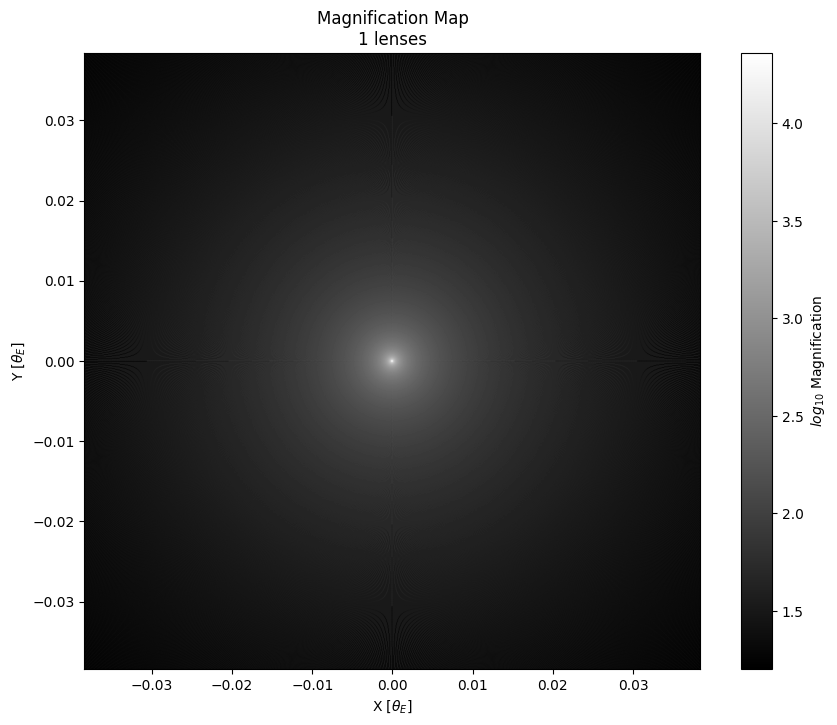

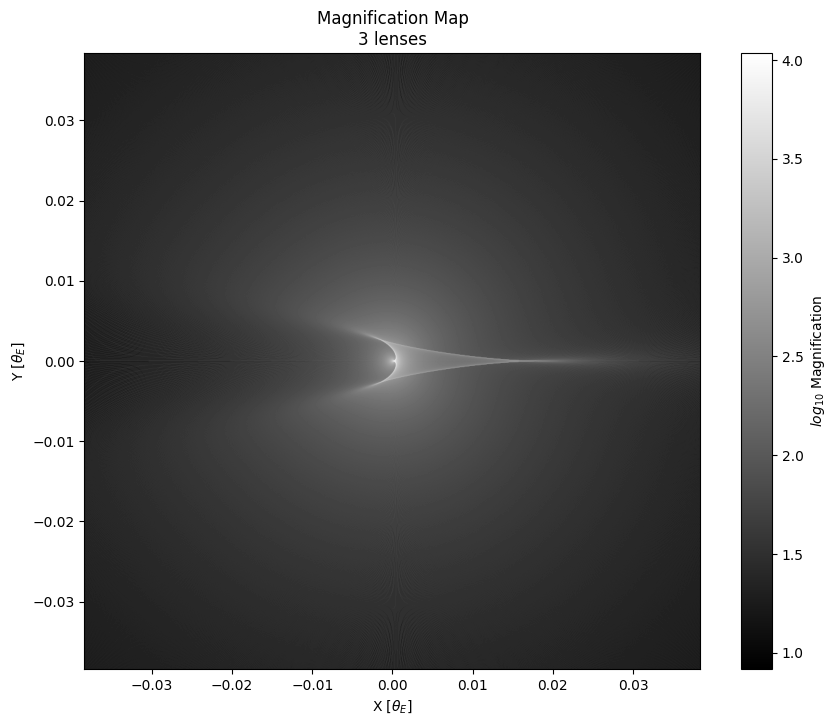

In [11]:
single_lens.plot_mags_map()
triple_lens.plot_mags_map()

plt.show()

In [15]:
def get_line_box_intersections(u, alpha, W):
    alpha = np.deg2rad(alpha)
    
    intersections = []

    # Starting point of line
    x0 = -u * np.sin(alpha)
    y0 = u * np.cos(alpha)

    # Direction vector of line
    dx = np.cos(alpha)
    dy = np.sin(alpha)

    # Vertical edges
    for x_edge in [-W/2, W/2]:
        t = (x_edge - x0) / dx
        y = y0 + t*dy
        if -W/2 <= y <= W/2:
            intersections.append((x_edge, y))
    
    # Horizontal edges
    for y_edge in [-W/2, W/2]:
        t = (y_edge - y0) / dy
        x = x0 + t*dx
        if -W/2 <= x <= W/2:
            intersections.append((x, y_edge))
    
    return intersections

In [ ]:
from skimage.draw import line

# Get the intersections of the line with the box edges
intersections = get_line_box_intersections(u, alpha, binary_mag_map.ang_width)

start = intersections[0]
end = intersections[1]

brightnesses = convolved_brightness_differences_list[0]

offset = (binary_mag_map.pixels - 1) / 2.0

print(offset)

start = np.floor(start/binary_mag_map.ang_res + offset)
end = np.floor(end/binary_mag_map.ang_res + offset)

# Get line pixel coordinates
rr, cc = line(int(start[1]), int(start[0]), int(end[1]), int(end[0]))

# Get brightness values along the line
line_values = brightnesses[rr[1:], cc[1:]]

print(np.shape(line_values))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

ax.imshow(brightnesses, cmap=cmap, extent=[0, binary_mag_map.pixels, 0, binary_mag_map.pixels])
ax.scatter(cc[1:], rr[1:], s=5, color='red')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

ax.plot(line_values)
ax.set_xlabel("Sample Index Along Line")
ax.set_ylabel("Brightness")
ax.grid(True)

plt.show()